Imagine the following situation: you have two tables, one with event logs, and the other with status changes. To make this concrete, let's take our events to be purchases by our users, and the status changes to be when the users attained a Gold Membership (wow so shiny). You want to use their membership status _at the time of each purchase_ as a feature for some model, but you only have records of when the status _changed_, so you can't just naively join the tables.

After inheriting some code that was performing this operation manually using `groupby`'s and fancy indexing, I decided to check if Pandas had a built in function for it, and I was pleasantly surprised: [`pandas.merge_asof`](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.merge_asof.html). Let's check out how it works.

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# https://johnpaton.net/posts/custom-color-schemes-in-matplotlib/
plt.style.use('~/johnpaton.mplstyle')

/Users/johnpaton/.virtualenvs/data-science/lib/python3.7/site-packages/matplotlib/style/core.py:112: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  _apply_style(rc)


We'll begin by generating some fake sales data. We'l have three users: Alice, Bob, and Charlie, who made purchases over the last year. Sorry about the verbosity, there doesn't seem to be any easier way to generate random dates in a range. 

In [2]:
n_rows = 15
epoch = datetime.utcfromtimestamp(0)
end = (datetime.now() - epoch).days
start = (datetime.now() - timedelta(days=365) - epoch).days

users = ['alice','bob','charlie']
df_sales = pd.DataFrame(data={
    'timestamp': pd.to_datetime(np.random.randint(start, end, n_rows), unit='D'),
    'user': np.random.choice(users, n_rows),
    'amount': np.random.randint(0,100, n_rows)
}).sort_values('timestamp').reset_index(drop=True)
df_sales

,timestamp,user,amount
0,2018-04-14,charlie,74
1,2018-05-02,alice,61
2,2018-05-17,charlie,85
3,2018-06-25,bob,71
4,2018-06-30,alice,50
5,2018-07-04,charlie,40
6,2018-09-22,bob,64
7,2018-11-02,alice,7
8,2018-11-18,bob,57
9,2018-11-21,alice,37


Next up, we need the records of when each of them attained their coveted Gold Membership:

In [3]:
df_flags = pd.DataFrame(data={
    'user': users,
    'timestamp': pd.to_datetime(np.random.randint(start, end, len(users)), unit='D'),
    'status': 'gold_member'
}).sort_values('timestamp').reset_index(drop=True)
df_flags

,user,timestamp,status
0,charlie,2018-04-18,gold_member
1,bob,2018-06-09,gold_member
2,alice,2018-09-24,gold_member


Now it's time to do our merge. We call `pd.merge_asof`, specifying the following fields:
* The `left` and `right` dataframes
* The column to merge `on` (this is generally a time column or some other ordering field)
* The column(s) to group `by`. The `by` keyword is very nice, as we can use it to make sure that the status changes only get propagated across the correct users' purchases. Otherwise we would have to ensure this manually.

In [4]:
df_merged = pd.merge_asof(
    df_sales,
    df_flags,
    on='timestamp',
    by='user',
)
df_merged

,timestamp,user,amount,status
0,2018-04-14,charlie,74,NaN
1,2018-05-02,alice,61,NaN
2,2018-05-17,charlie,85,gold_member
3,2018-06-25,bob,71,gold_member
4,2018-06-30,alice,50,NaN
5,2018-07-04,charlie,40,gold_member
6,2018-09-22,bob,64,gold_member
7,2018-11-02,alice,7,gold_member
8,2018-11-18,bob,57,gold_member
9,2018-11-21,alice,37,gold_member


The result is kind of like a left join, in that all "matching" rows are filled and unmatched rows are `NaN`. However, unlike in a left join (which looks for an exact match), in this the join applied to case all rows on the left that have a `timestamp` that comes _after_ the paired rows on the right. To ensure that this before/after comparison is possible, the DataFrames must be sorted by the `on` column.

To create our Gold Membership flag, all we do is just replace the name of the event with a `1` and fill the `NaN`s (which are rows that came before the status change) with `0`s.

In [5]:
df_merged['gold_member'] = df_merged['status']\
    .replace('gold_member', 1)\
    .fillna(0)\
    .astype(int)
df_merged

,timestamp,user,amount,status,gold_member
0,2018-04-14,charlie,74,NaN,0
1,2018-05-02,alice,61,NaN,0
2,2018-05-17,charlie,85,gold_member,1
3,2018-06-25,bob,71,gold_member,1
4,2018-06-30,alice,50,NaN,0
5,2018-07-04,charlie,40,gold_member,1
6,2018-09-22,bob,64,gold_member,1
7,2018-11-02,alice,7,gold_member,1
8,2018-11-18,bob,57,gold_member,1
9,2018-11-21,alice,37,gold_member,1


To make sure there's no funny business going on, we can also visualize exactly what happened:

/Users/johnpaton/.virtualenvs/data-science/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


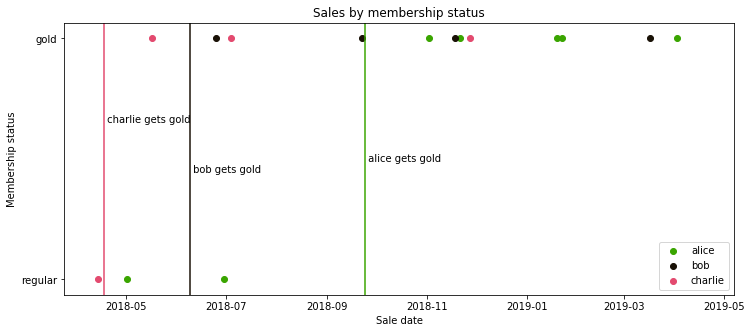

In [6]:
fig, ax = plt.subplots(facecolor='white', figsize=(12,5))
for user in users:
    df_tmp = df_merged[df_merged['user'] == user]
    plt.scatter(df_tmp['timestamp'], df_tmp['gold_member'], label=user)
    
for i,row in df_flags.sort_values('user').reset_index().iterrows():
    plt.axvline(row['timestamp'], c=f'C{i}')
    plt.annotate(
        f" {row['user']} gets gold", (row['timestamp'], np.random.uniform(0.25,0.75))
    )
plt.yticks([0,1], ['regular', 'gold'])
plt.ylabel('Membership status')
plt.xlabel('Sale date')
plt.title('Sales by membership status')
plt.legend();

So now we have a nice feature that can be used in a training set, without any data leakage (no events from the future are visible before they happened in the training set).

This also works for multiple status changes. For example, say Bob got demoted on February 1st back to being a normal user.

In [7]:
df_flags = pd.concat([
    df_flags,
    pd.DataFrame(data={
        'user': ['bob'],
        'status': 'normal',
        'timestamp': pd.to_datetime('2019-02-01')
        
    })
])
df_flags

/Users/johnpaton/.virtualenvs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,status,timestamp,user
0,gold_member,2018-04-18,charlie
1,gold_member,2018-06-09,bob
2,gold_member,2018-09-24,alice
0,normal,2019-02-01,bob


If we perform the `merge_asof` again, we see that Bob's status changes twice, just how we would expect:

In [8]:
pd.merge_asof(
    df_sales,
    df_flags,
    on='timestamp',
    by='user',
)

,timestamp,user,amount,status
0,2018-04-14,charlie,74,NaN
1,2018-05-02,alice,61,NaN
2,2018-05-17,charlie,85,gold_member
3,2018-06-25,bob,71,gold_member
4,2018-06-30,alice,50,NaN
5,2018-07-04,charlie,40,gold_member
6,2018-09-22,bob,64,gold_member
7,2018-11-02,alice,7,gold_member
8,2018-11-18,bob,57,gold_member
9,2018-11-21,alice,37,gold_member


Finally, these have all been examples of so-called "backwards searches". From the [Pandas docs](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.merge_asof.html): 
> A “backward” search selects the last row in the right DataFrame whose ‘on’ key is less than or equal to the left’s key.

Somewhat counterintuitively, this causes the status changes to propagate _forward_ in time. This is the default behaviour of `merge_asof`. To do the reverse (a _forward_ search, a.k.a. propagate changes _backwards_ in time), you can provide the keyword argument `direction="forward"`. 